### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [19]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [20]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [21]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [22]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [23]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [24]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [25]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [26]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x0000017D07A23E50>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [27]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [28]:
pol_list = []
pol_list.append(create_policy({}, name="Zero"))

for dm in [1, 10]:
    for location in [0, 1, 2, 3, 4]:
        for ews_days in [2, 4]:
            pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days},
                                          name=f"Dike_{dm}dm_RfR_{location}_EWS_{ews_days}d"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [29]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 25
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 3 workers
[MainProcess/INFO] performing 25 scenarios * 20 policies * 1 model(s) = 500 experiments
100%|████████████████████████████████████████| 500/500 [01:40<00:00,  4.98it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [30]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
0,2.219307e+08,2.029929e+07,84600000.0,9556.804784,0.029686,1.049088e+08,3.268395e+08,Policy_Dike_1dm_RfR_0_EWS_2d
1,7.080967e+08,2.029929e+07,84600000.0,30249.488865,0.094015,1.049295e+08,8.130263e+08,Policy_Dike_1dm_RfR_0_EWS_2d
2,2.078111e+08,2.029929e+07,84600000.0,10276.774057,0.026734,1.049096e+08,3.127207e+08,Policy_Dike_1dm_RfR_0_EWS_2d
3,6.439178e+08,2.029929e+07,84600000.0,24516.117153,0.161470,1.049238e+08,7.488416e+08,Policy_Dike_1dm_RfR_0_EWS_2d
4,2.235462e+09,2.029929e+07,84600000.0,26496.681279,0.239262,1.049258e+08,2.340388e+09,Policy_Dike_1dm_RfR_0_EWS_2d
...,...,...,...,...,...,...,...,...
495,4.746275e+08,4.421502e+07,256100000.0,41094.344461,0.053551,3.003561e+08,7.749836e+08,Policy_Dike_10dm_RfR_4_EWS_4d
496,1.822496e+08,4.421502e+07,256100000.0,15194.263509,0.012790,3.003302e+08,4.825798e+08,Policy_Dike_10dm_RfR_4_EWS_4d
497,6.744156e+07,4.421502e+07,256100000.0,3799.707462,0.007364,3.003188e+08,3.677604e+08,Policy_Dike_10dm_RfR_4_EWS_4d
498,1.085147e+09,4.421502e+07,256100000.0,68860.806899,0.106950,3.003839e+08,1.385531e+09,Policy_Dike_10dm_RfR_4_EWS_4d


In [31]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [32]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Number of Deaths                      \
                                                   mean       min       max   
policy                                                                        
Policy_Dike_10dm_RfR_0_EWS_2d                  0.079855  0.005451  0.239262   
Policy_Dike_10dm_RfR_0_EWS_4d                  0.063884  0.004361  0.191409   
Policy_Dike_10dm_RfR_1_EWS_2d                  0.081943  0.005451  0.238624   
Policy_Dike_10dm_RfR_1_EWS_4d                  0.065554  0.004361  0.190899   
Policy_Dike_10dm_RfR_2_EWS_2d                  0.140786  0.005630  0.281692   
Policy_Dike_10dm_RfR_2_EWS_4d                  0.112629  0.004504  0.225353   
Policy_Dike_10dm_RfR_3_EWS_2d                  0.136702  0.009122  0.280530   
Policy_Dike_10dm_RfR_3_EWS_4d                  0.109362  0.007298  0.224424   
Policy_Dike_10dm_RfR_4_EWS_2d                  0.144662  0.009204  0.282743   
Policy_Dike_10dm_RfR_4_EWS_4d                  0.115729  0.007364  0.226194   
Policy_Dike_1dm_RfR_0_EWS_2d                   0.163582  0.018066  0.708767   
Policy_Dike_1dm_RfR_0_EWS_4d                   0.130866  0.014453  0.567013   
Policy_Dike_1dm_RfR_1_EWS_2d                   0.165650  0.018066  0.708535   
Policy_Dike_1dm_RfR_1_EWS_4d                   0.132520  0.014453  0.566828   
Policy_Dike_1dm_RfR_2_EWS_2d                   0.189197  0.017942  0.723598   
Policy_Dike_1dm_RfR_2_EWS_4d                   0.151357  0.014354  0.578878   
Policy_Dike_1dm_RfR_3_EWS_2d                   0.198692  0.015682  0.736133   
Policy_Dike_1dm_RfR_3_EWS_4d                   0.158954  0.012546  0.588906   
Policy_Dike_1dm_RfR_4_EWS_2d                   0.216284  0.015987  0.743465   
Policy_Dike_1dm_RfR_4_EWS_4d                   0.173027  0.012790  0.594772   

                                                  Expected Annual Damage  \
                                    q05       q95                   mean   
policy                                                                     
Policy_Dike_10dm_RfR_0_EWS_2d  0.008713  0.236810           7.117248e+08   
Policy_Dike_10dm_RfR_0_EWS_4d  0.006971  0.189448           7.117248e+08   
Policy_Dike_10dm_RfR_1_EWS_2d  0.008743  0.236801           7.377826e+08   
Policy_Dike_10dm_RfR_1_EWS_4d  0.006994  0.189441           7.377826e+08   
Policy_Dike_10dm_RfR_2_EWS_2d  0.015689  0.279932           1.271834e+09   
Policy_Dike_10dm_RfR_2_EWS_4d  0.012551  0.223946           1.271834e+09   
Policy_Dike_10dm_RfR_3_EWS_2d  0.014716  0.276640           1.230352e+09   
Policy_Dike_10dm_RfR_3_EWS_4d  0.011773  0.221312           1.230352e+09   
Policy_Dike_10dm_RfR_4_EWS_2d  0.016359  0.281262           1.294096e+09   
Policy_Dike_10dm_RfR_4_EWS_4d  0.013087  0.225009           1.294096e+09   
Policy_Dike_1dm_RfR_0_EWS_2d   0.024291  0.530423           1.011457e+09   
Policy_Dike_1dm_RfR_0_EWS_4d   0.019433  0.424338           1.011457e+09   
Policy_Dike_1dm_RfR_1_EWS_2d   0.024720  0.530423           1.037483e+09   
Policy_Dike_1dm_RfR_1_EWS_4d   0.019776  0.424338           1.037483e+09   
Policy_Dike_1dm_RfR_2_EWS_2d   0.022403  0.482550           1.451245e+09   
Policy_Dike_1dm_RfR_2_EWS_4d   0.017922  0.386040           1.451245e+09   
Policy_Dike_1dm_RfR_3_EWS_2d   0.024422  0.518109           1.459501e+09   
Policy_Dike_1dm_RfR_3_EWS_4d   0.019538  0.414487           1.459501e+09   
Policy_Dike_1dm_RfR_4_EWS_2d   0.030739  0.551993           1.557308e+09   
Policy_Dike_1dm_RfR_4_EWS_4d   0.024591  0.441595           1.557308e+09   

                                                                         \
                                        min           max           q05   
policy                                                                    
Policy_Dike_10dm_RfR_0_EWS_2d  3.565389e+07  2.301500e+09  6.279905e+07   
Policy_Dike_10dm_RfR_0_EWS_4d  3.565389e+07  2.301500e+09  6.279905e+07   
Policy_Dike_10dm_RfR_1_EWS_2d  3.565389e+07  2.303444e+09  6.279905e+07   
Policy_Dike_1

In [33]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

### Plots

TODO: Make make some nice Seaborn plots?

<AxesSubplot:xlabel='policy'>

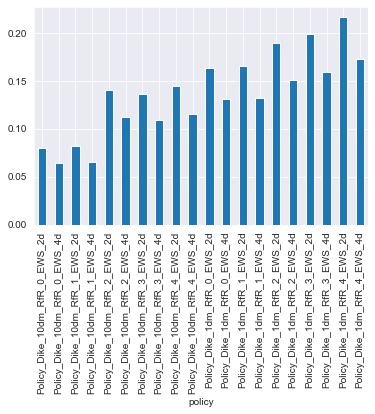

In [34]:
TCA_df["Expected Number of Deaths"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

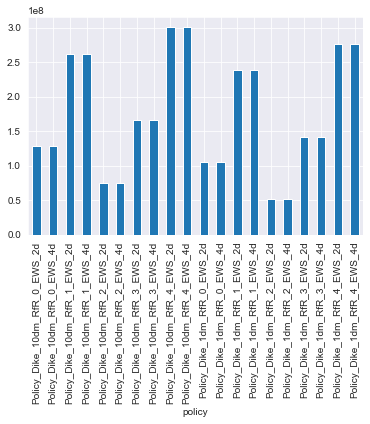

In [35]:
TCA_df["Total Costs"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

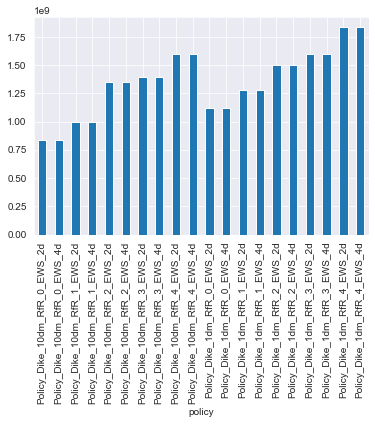

In [36]:
TCA_df["Cost plus Damage"]["mean"].plot.bar()